In [1]:
# Step 1: Install necessary libraries
!pip install tensorflow

In [2]:
# Step 2: Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, VGG19
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, ReLU, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt


In [3]:
# Step 3: Define parameters
learning_rate = 0.001
batch_size = 64
epochs = 56
N1 = 5  # Data augmentation multiplier Al_Khalid
N2 = 2   # Data augmentation multiplier T_90

In [4]:
# Step 4: Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Training Data

In [5]:
# Define classes
class_names = ['Al_Khalid', 'T_90']

# Step 5: Define path, load and preprocess the data
train_class_1_path = 'Downloads/IMGs/Train/Al_Khalid'
train_class_2_path = 'Downloads/IMGs/Train/T_90'


def load_and_preprocess_image(image_path):
    # Read the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode image with 3 channels

    # Resize the image using TensorFlow
    image = tf.image.resize(image, [224, 224], method="mitchellcubic")
    
    # Normalize pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    
    return image

train_class_1_images = [os.path.join(train_class_1_path, img) for img in os.listdir(train_class_1_path)]
train_class_2_images = [os.path.join(train_class_2_path, img) for img in os.listdir(train_class_2_path)]
print(len(train_class_1_images)+len(train_class_2_images))
train_class_1_images = np.array([load_and_preprocess_image(img) for img in train_class_1_images])
train_class_2_images = np.array([load_and_preprocess_image(img) for img in train_class_2_images])

198


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


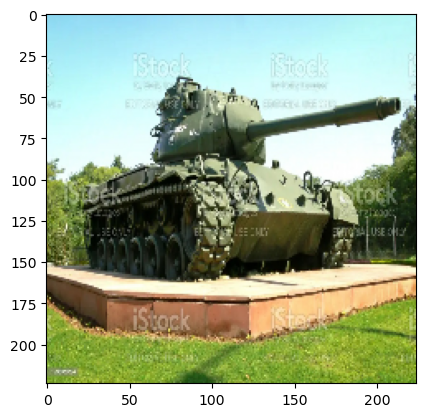

In [6]:
plt.imshow(train_class_1_images[1])

In [7]:
# Step 6: Apply data augmentation N times
augmented_images = []
augmented_labels = []

# Augment class 1 images N1 times
print("Augmenting class 1 images...")
for _ in range(N1):
    for x_batch, y_batch in datagen.flow(train_class_1_images, to_categorical(np.zeros(len(train_class_1_images)), num_classes=len(class_names)), batch_size=len(train_class_1_images)):
        print(f"Generated {len(x_batch)} augmented images for class 1")
        augmented_images.append(x_batch)
        augmented_labels.append(y_batch)
        print("Class 1 augmentation done")
        break
        
print(len(augmented_labels))

# Augment class 2 images N2 times
print("Augmenting class 2 images...")
for _ in range(N2):
    for x_batch, y_batch in datagen.flow(train_class_2_images, to_categorical(np.ones(len(train_class_2_images)), num_classes=len(class_names)), batch_size=len(train_class_2_images)):
        print(f"Generated {len(x_batch)} augmented images for class 2")
        augmented_images.append(x_batch)
        augmented_labels.append(y_batch)
        print("Class 2 augmentation done")
        break
        
print(len(augmented_labels))
        
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

print("Data augmentation complete.")

Augmenting class 1 images...
Generated 69 augmented images for class 1
Class 1 augmentation done
Generated 69 augmented images for class 1
Class 1 augmentation done
Generated 69 augmented images for class 1
Class 1 augmentation done
Generated 69 augmented images for class 1
Class 1 augmentation done
Generated 69 augmented images for class 1
Class 1 augmentation done
5
Augmenting class 2 images...
Generated 129 augmented images for class 2
Class 2 augmentation done
Generated 129 augmented images for class 2
Class 2 augmentation done
7
Data augmentation complete.


In [8]:
len(augmented_images)

603

In [9]:
# Step 7: Create labels (0 for class_1 and 1 for class_2)
train_class_1_labels = np.zeros((len(train_class_1_images), len(class_names)))
train_class_1_labels[:, 0] = 1

train_class_2_labels = np.ones((len(train_class_2_images), len(class_names)))
train_class_2_labels[:, 1] = 1

augmented_multiclass_labels = np.array(augmented_labels)

In [10]:
print(train_class_2_labels.shape)

(129, 2)


In [11]:
# Step 8: Concatenate and shuffle data
train_images = np.concatenate([train_class_1_images, train_class_2_images, augmented_images])
train_labels = np.concatenate([train_class_1_labels, train_class_2_labels, augmented_multiclass_labels])
train_images, train_labels = shuffle(train_images, train_labels, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


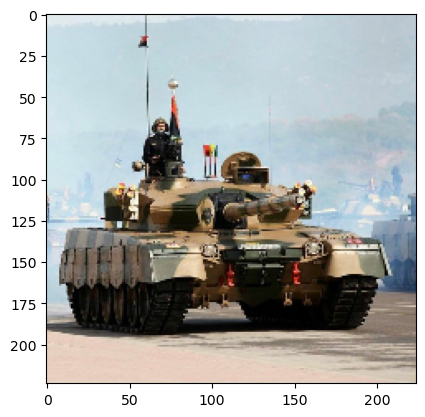

In [12]:
plt.imshow(train_images[0])

In [13]:
print(train_labels[0])

[1. 0.]


In [14]:
# Step 9: Apply train-validation split
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=0)

In [15]:
print(len(y_train))
print(len(y_val))

640
161


In [16]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

# Flatten y_train to a 1D array if necessary
y_train_flat = y_train.flatten()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)

# Convert class weights to a dictionary
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train_flat), class_weights)}

class_weight_dict

{0.0: 1.191806331471136, 1.0: 0.8613728129205922}

# Test Data

In [17]:
# Define class names
class_names = ['Al_Khalid', 'T_90']

# Define paths
test_class_1_path = 'Downloads/IMGs/Test/Al_Khalid'
test_class_2_path = 'Downloads/IMGs/Test/T_90'

# Load and preprocess the data
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224,224], method="mitchellcubic")
    
         
    #image = tf.image.central_crop(image, central_fraction=224 / 256)  # Use central_fraction to specify the fraction to keep
    #image = tf.keras.applications.resnet50.preprocess_input(image)
    image = image / 255.0    # Normalize pixel values to the range [0, 1]
    return image

test_class_1_images = [os.path.join(test_class_1_path, img) for img in os.listdir(test_class_1_path)]
test_class_2_images = [os.path.join(test_class_2_path, img) for img in os.listdir(test_class_2_path)]

test_class_1_images = np.array([load_and_preprocess_image(img) for img in test_class_1_images])
test_class_2_images = np.array([load_and_preprocess_image(img) for img in test_class_2_images])

# Create labels for multiclass
test_class_1_labels = np.zeros((len(test_class_1_images), len(class_names)))
test_class_2_labels = np.ones((len(test_class_2_images), len(class_names)))

# Concatenate images and labels
x_test = np.concatenate([test_class_1_images, test_class_2_images])
y_test = np.concatenate([test_class_1_labels, test_class_2_labels])

# Shuffle the data and labels
x_test, y_test = shuffle(x_test, y_test, random_state=42)

# Model

In [18]:
from keras.initializers import he_uniform, GlorotUniform
from tensorflow.keras.regularizers import l2

# Step 11: Build the model using VGG19 architecture
# Input layer
input_layer = Input(shape=(224, 224, 3))

# Load VGG19 model (excluding top layers and with imagenet weights)
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)

# Convolutional layers from VGG19
x = base_model.output

# Fully connected layers
x = Flatten()(x)
x = Dense(4096, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01) )(x)

# Output layer
output_layer = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

In [19]:
# Step 12: Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Step 13: Define callbacks
early_stop = EarlyStopping(patience=8, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_4.h5', save_best_only=True)

In [21]:
# Step 14: Train the model
steps_per_epoch = len(x_train) // batch_size

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, model_checkpoint], class_weight = class_weight_dict
)

Epoch 1/56
10/10 [==============================] - ETA: 0s - loss: 150.6226 - accuracy: 0.5469  

C:\Users\21845\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 5081s 527s/step - loss: 150.6226 - accuracy: 0.5469 - val_loss: 43.9910 - val_accuracy: 0.3230
Epoch 2/56
10/10 [==============================] - 3528s 356s/step - loss: 94.9674 - accuracy: 0.5734 - val_loss: 822.1041 - val_accuracy: 0.6770
Epoch 3/56
10/10 [==============================] - 3520s 355s/step - loss: 187715104.0000 - accuracy: 0.5406 - val_loss: 2628606208.0000 - val_accuracy: 0.6770
Epoch 4/56
10/10 [==============================] - 3536s 357s/step - loss: 182918580273152.0000 - accuracy: 0.5312 - val_loss: 4610782146854912.0000 - val_accuracy: 0.3230
Epoch 5/56
10/10 [==============================] - 3541s 357s/step - loss: 2645856534742958080.0000 - accuracy: 0.5125 - val_loss: nan - val_accuracy: 0.6770
Epoch 6/56
10/10 [==============================] - 3550s 358s/step - loss: nan - accuracy: 0.6781 - val_loss: nan - val_accuracy: 0.6770
Epoch 7/56
10/10 [==============================] - 3561s 359s/step - loss: nan - accu

In [22]:
# Step 15: Load the best model
model = tf.keras.models.load_model('best_model_4.h5')

In [23]:
# Step 16: Evaluate the model
y_pred = model.predict(x_test)
y_pred_class = np.round(y_pred).astype(int)

accuracy = np.mean(y_pred_class.flatten() == y_test.flatten())
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test.flatten(), y_pred_class.flatten())
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test.flatten(), y_pred_class.flatten(), target_names=class_names)
print("Classification Report:\n", class_report)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_auc)

2/2 [==============================] - 80s 27s/step
Accuracy: 0.5
Confusion Matrix:
 [[17 17]
 [32 32]]
Classification Report:
               precision    recall  f1-score   support

   Al_Khalid       0.35      0.50      0.41        34
        T_90       0.65      0.50      0.57        64

    accuracy                           0.50        98
   macro avg       0.50      0.50      0.49        98
weighted avg       0.55      0.50      0.51        98

ROC-AUC Score: 0.47794117647058826


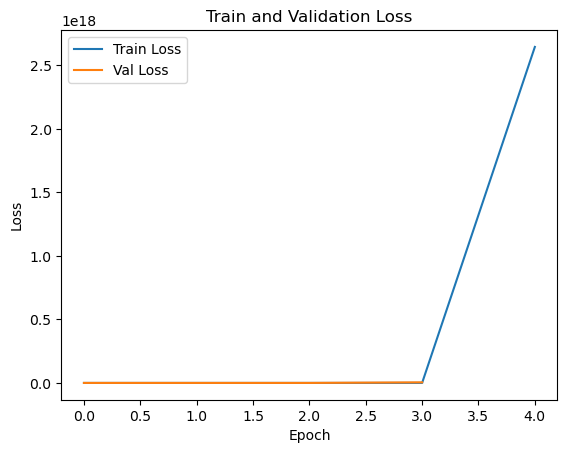

In [24]:
# Step 17: Plot train and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.show()